# Рекомендация тарифов

## Описание проекта

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Предобработка данных уже сделана.

**Цель** - построить модель для задачи классификации, которая выберет подходящий тариф.

**Тип задачи** - классификация (бинарная классификация).

**Целевая метрика** - *accuracy*.

**Целевое значение метрики** *accuracy* - не менее 0.75 на тестовой выборке. 

## Описание данных
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
- `сalls` - количество звонков,
- `minutes` - суммарная длительность звонков в минутах,
- `messages` - количество sms-сообщений,
- `mb_used` - израсходованный интернет-трафик в Мб,
- `is_ultra` - каким тарифом пользовался в течение месяца («Ультра» - 1, «Смарт» - 0).

**Целевой признак** - `is_ultra`.

## Импорт необходимых модулей

Сделаем проверку присутствиия библиотеки `imbalanced-learn` и установим её, если она отсутствует.

In [2]:
packages = !conda list 'imbalanced.*' --canonical

if len(packages) == 1 and packages[-1] == '':
    print('Пакет "imbalanced-learn" не установлен.\nНачинаем установку.\n')
    !conda install -c conda-forge imbalanced-learn -y
else:
    print(f'Пакет "imbalanced-learn" не установлен.\n{packages[-1]}', sep='\n')

Пакет "imbalanced-learn" не установлен.
conda-forge/noarch::imbalanced-learn-0.7.0-py_1


In [3]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA

from sklearn.dummy import DummyClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

import pandas as pd
from pandas.plotting import scatter_matrix

%matplotlib inline

## Откройте и изучите файл

Откроем файл.

In [4]:
try:
    data = pd.read_csv('/datasets/users_behavior.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')
    
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Проверим типы данных.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Так как мы решаем задчу бинарной классификации, проверим нет ли смещения в целевых классах, то есть сравним доли абонентов выбравших тарифных план «Ультра» и тарифный план «Смарт».

In [6]:
def check_target_imbalance(vals):
    mean_val = vals.mean()
    print(f'Доля абонентов, выбравших тарифный план «Ультра» {mean_val:.2%}')
    print(f'Доля абонентов, выбравших тарифный план «Смарт» {1 - mean_val:.2%}')
    
check_target_imbalance(data.is_ultra)

Доля абонентов, выбравших тарифный план «Ультра» 30.65%
Доля абонентов, выбравших тарифный план «Смарт» 69.35%


Мы можем наблюдать небольшой дисбаланс классов в датасете, чтобы снизить влияние дисбаланса на модель будем использовать следующие приёмы:
1. При разделении на тестовую и тренировочную выборки будем использовать стратификацию.
2. Попробуем использовать технику апсемплинга.

In [7]:
if data.duplicated().any():
    print('В данных есть дубликаты!')
else:
    print('Дубликаты не обнаружены.')

Дубликаты не обнаружены.


## Разбейте данные на выборки

В переменную `X` копируем обучающие признаки, в переменную `y` копируем целевой признак.

In [16]:
X = data.drop(columns = 'is_ultra')
y = data.is_ultra.copy()

Разделим данные на тренировачный и тестовый наборы. Под тестовый набор выдлим 20% данных.

Чтобы получать воспроизводимые результаты будем использовать параметр `random_state` равным 42.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Проверим дисбаланс классов в тренировочной выборке.

In [18]:
check_target_imbalance(y_train)

Доля абонентов, выбравших тарифный план «Ультра» 30.65%
Доля абонентов, выбравших тарифный план «Смарт» 69.35%


Проверим дисбаланс классов в тестовой выборке.

In [19]:
check_target_imbalance(y_test)

Доля абонентов, выбравших тарифный план «Ультра» 30.64%
Доля абонентов, выбравших тарифный план «Смарт» 69.36%


Как и ожидалось пропорции классов совпадают.

Чтобы сохранить максимально возможное количество данных для тренировки моделей, будем использовать технику крос-валидации (k-fold cross-validation) для подбора гиперпараметров и оценки метрик на тренировочной выборке.

Прежде чем переходить к исследованию моделей, посмотрим а гистограммы распределений и диаграммы рассеяния признаков в тренировочном наборе, а также проверим нет ли среди них сильноскоррелированных.

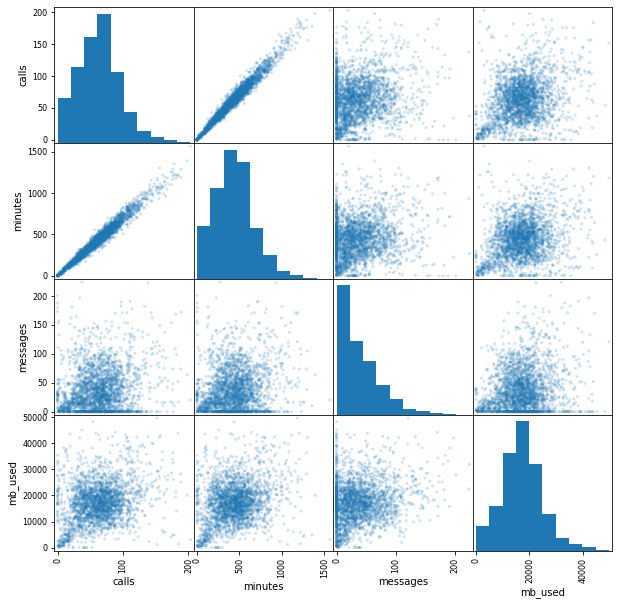

In [20]:
scatter_matrix(X_train, figsize=(10, 10), alpha=0.2)
plt.show()

Построим матрицу корреляции.

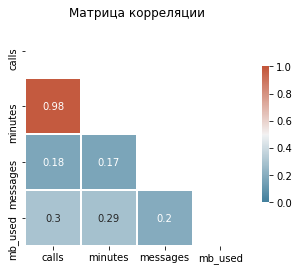

In [21]:
def plot_corr_matrix(df):
    corr = df.corr()
    
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    f, ax = plt.subplots(figsize=(5, 5))
    
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    sns.heatmap(corr,
                mask=mask,
                cmap=cmap,
                annot=True,
                vmax=1,
                vmin=0,
                center=0.5,
                square=True,
                linewidths=1.0, 
                cbar_kws={"shrink": 0.5},
                ax=ax
               )
    
    ax.set_title('Матрица корреляции')
    
    plt.show()
    
plot_corr_matrix(X_train)

Распределения некоторых признаков по форме отличается от нормального, а сами признаки имеют разные порядки величин, например (`call` и `mb_used`), поэтому может быть целесообразным использовать стандартизацию перед обучением моделей.

Признаки `calls` и `minutes` сильно имеют очень сильную корреляцию (коэффициент корреляции приблизительно равен 0.98), что может негативно влиять обучение моделей. Возможно, с этими признаками придётся выполнить дополнительные пробразования.

## Исследуйте модели

Напишем несколько функций, позволяющих быстро оценить модели.

In [22]:
def print_score(estimator, features, target, score='accuracy', cv=5, n_jobs=1):
    '''Вычисляет среднее, минимальной и максимальное значение метрики,
    полученное с помощью кросс-валидации.
    '''
    
    scores = cross_val_score(estimator,
                             X = features,
                             y = target,
                             cv=cv,
                             scoring=score,
                             n_jobs=n_jobs,
                            )
    
    return pd.DataFrame(scores, columns=[score]).agg(['mean', 'min', 'max']).transpose()

In [23]:
def plot_roc_curve(y_train, y_scores, ax=None, style='', label=None):
    '''Выводит на экран кривую ROC.'''
    
    fpr, tpr, thresholds = roc_curve(y_train, y_scores)
    
    axes_flag = ax is None
    
    if axes_flag:
        fig, ax = plt.subplots(1, 1)
    
    ax.plot(fpr, tpr, style, label=label)
    
    if axes_flag:
        ax.plot([0,1], [0,1], 'k--', label='Random classifier')
        ax.grid()
        ax.set_xlim((0, 1))
        ax.set_ylim((0, 1))
        
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        
        ax.legend(loc='lower right')
        
        ax.set_title('ROC curve')
        return fig, ax
    
    return ax

In [24]:
def evaluate_model(model, X, y, label, method='decision_function', n_jobs=1):
    '''Выводит на экран сводку о производительности модели, состоящую из метрик
    accuracy, f1, roc_auc и кривую ROC.
    '''
    
    df = pd.DataFrame(columns= ['mean', 'min', 'max'])
    
    for metric in ['accuracy', 'f1', 'roc_auc']:
        df = pd.concat([df, print_score(model, X, y, score=metric, n_jobs=n_jobs)])
        
    print(f'Метрики для {label}')
    
    display(df)
    
    y_scores = cross_val_predict(model, X, y, cv=5, method=method, n_jobs=n_jobs)
    if method == 'predict_proba':
        y_scores = y_scores[:, -1]
        
    fig, ax = plot_roc_curve(y_train, y_scores, label=label)
    plt.show()

Сравним несколько моделей, а для лучшей выполним настройку гиперпараметров.

### Базовая модель

В качестве базовой модели выберем `DummyClassifier`, который будет предсказывать целевое значение случайным образом, при этом зададим параметр `strategy` равным `stratified`, чтобы распределение классов повторяло распределение в тренировочном наборе данных. 

Создадим классификатор и оценим его производительность.

Метрики для DummyClassifier


,mean,min,max
accuracy,0.570599,0.561165,0.583658
f1,0.283444,0.251613,0.318182
roc_auc,0.494969,0.463390,0.530490


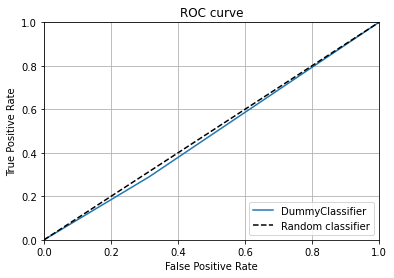

In [25]:
dummy_clf = DummyClassifier(strategy='stratified')

evaluate_model(model=dummy_clf, X=X_train, y=y_train, label='DummyClassifier', method='predict_proba', n_jobs=-1)

Полученные значения метрик примем за базовые и в конце сравним с ними лучший классификатор.

На графике `ROC curve` видно, что кривая классификатора немного отклоняется от пунктирной линии, проходящей через центр, но очень близка к ней, поэтому далее на аналогичных графиках будем рисовать только пунктирную прямую, вместо того, чтобы вычислять её с помощью `DummyClassifier`.

### LogisticRegression

Начнём с логистической регрессии. Это линейная модель, поэтому для неё важно, чтобы признаки имели единый масштаб. Будем выполнять стандартизацию признаков с помощью `StandardScaler`. Для классификатора установим параметр `class_weight` равным `balanced`, чтобы учесть дисбаланс классов.

Метрики для LogisticRegression


,mean,min,max
accuracy,0.627775,0.614786,0.645914
f1,0.496147,0.435530,0.533333
roc_auc,0.659505,0.610290,0.685038


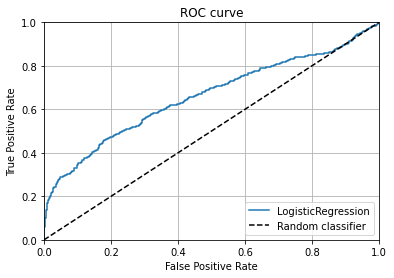

In [26]:
logpipe = make_pipeline(StandardScaler(), 
                        LogisticRegression(class_weight='balanced'),
                       )
evaluate_model(model=logpipe, X=X_train, y=y_train, label='LogisticRegression', n_jobs=-1)

Полученный результат определённо лучше, чем у базовой модели.

### DecisionTreeClassifier

Попробуем применить дерево решений. Деревья решений не должны быть чувствительны к различиям масштабов признаков, поэтому для начала обойдёмся без стандартизации.

Метрики для DefaultDecisionTree


,mean,min,max
accuracy,0.716464,0.687379,0.737354
f1,0.542058,0.506410,0.585670
roc_auc,0.665920,0.643557,0.693180


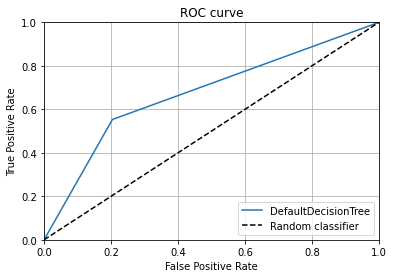

In [27]:
evaluate_model(model=DecisionTreeClassifier(), X=X_train, y=y_train, label='DefaultDecisionTree', method='predict_proba', n_jobs=-1)

Результаты лучше чем у логистической регрессии.

### RandomForestClassifier

Напоследок, проверим `RandomForestClassifier`.

Метрики для RandomForest


,mean,min,max
accuracy,0.796581,0.778210,0.821012
f1,0.628621,0.582734,0.690909
roc_auc,0.794058,0.771361,0.813433


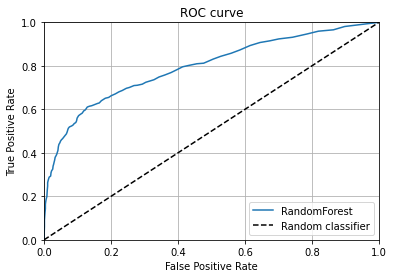

In [28]:
forest = RandomForestClassifier()
evaluate_model(model=forest, X=X_train, y=y_train, method='predict_proba', label='RandomForest', n_jobs=-1)

Результат существенно лучше, чем у двух предыдущих моделей. 

Предположим, что на результаты модели влияют дисбаланс классов и наличие корреляции между признаками, чтобы избавиться от влияния этих факторов добавим в конвейер стандартизацию, апсемплинг (чтобы устранить дисбаланс классов) и разложение на главные компоненты (чтобы устранить корреляцию).

Метрики для forest_pipline


,mean,min,max
accuracy,0.761572,0.747082,0.776265
f1,0.608740,0.569697,0.645768
roc_auc,0.778063,0.750914,0.802236


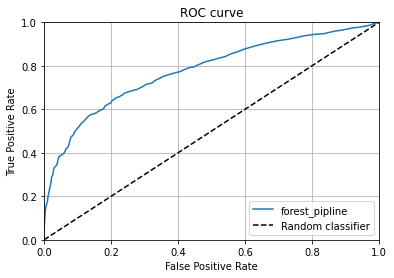

In [29]:
forest_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('oversampler', SMOTE()),
    ('pca', PCA()),
    ('classifier', RandomForestClassifier())
])

evaluate_model(model=forest_pipeline, X=X_train, y=y_train, method='predict_proba', label='forest_pipline', n_jobs=-1)

Результаты как-будто стали хуже, прежде чем браковать конвейер, попробуем настроить гиперпараметры.

Будем настраивать параметры апсемплинга, разложения на главные компоненты и самого классификатора, это приведёт к очень большому количеству различных вариантов параметров. Чтобы съэкономить время и иметь возможность удобно управлять количеством итераций при подборе гиперпараметров будем использовать `RandomizedSearchCV` вместо `GridSearchCV`.

Будем рассмптривать два варианта конвейра: с оверсемплингом и без и настраивать следующие гиперпараметры:
- `oversampler__k_neighbors` - количество ближайших соседей в алгоритме апсемплинга;
- `pca__n_components` - количество главных компонент, которые будут оставлены после разложения;
- `classifier__n_estimators` - количество деревьев решений в классификаторе;
- `classifier__max_depth` - максимальная глубина дерева;
- `classifier__min_samples_split` - минимальное количество наблюдений, которое может разделить узел дерева;
- `classifier__class_weight` - параметр, позволяющий учесть дисбаланс классов.

По условию задачи целевая метрика **accuracy**, поэтому будем выполнять оптимизацию гиперпараметров по ней.

In [30]:
forest_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('oversampler', SMOTE()),
    ('pca', PCA()),
    ('classifier', RandomForestClassifier()),
])


param_distribs = [
    {'oversampler': ['passthrough'],
     'pca__n_components': [2, 3, None],
     'classifier__n_estimators': list(range(1, 200)),
     'classifier__max_depth': list(range(1, 100)),
     'classifier__min_samples_split': list(range(2, 100)),
     'classifier__class_weight': [None, 'balanced'],
    },
    
    {'oversampler__k_neighbors': list(range(2, 100)),
     'pca__n_components': [2, 3, None],
     'classifier__n_estimators': list(range(1, 200)),
     'classifier__max_depth': list(range(1, 100)),
     'classifier__min_samples_split': list(range(2, 100)),
     'classifier__class_weight': [None, 'balanced'],
    }
]


rand_search = RandomizedSearchCV(estimator=forest_pipeline,
                                 param_distributions=param_distribs,
                                 n_iter=1000,
                                 scoring='accuracy',
                                 n_jobs=-1,
                                 cv=5,
                                 verbose=1,
                                )

rand_search.fit(X_train, y_train)

rand_search.best_params_

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


{'pca__n_components': 3,
 'oversampler': 'passthrough',
 'classifier__n_estimators': 26,
 'classifier__min_samples_split': 33,
 'classifier__max_depth': 52,
 'classifier__class_weight': None}

Победил конвейер без апсемплинга, его параметры приведены выше. Оценим производительность настроенной модели.

Метрики для forest_pipline


,mean,min,max
accuracy,0.802418,0.784466,0.828794
f1,0.623427,0.569288,0.669091
roc_auc,0.806619,0.782753,0.832397


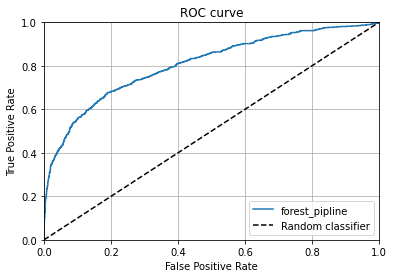

In [31]:
best_forest = rand_search.best_estimator_

evaluate_model(model=best_forest, X=X_train, y=y_train, method='predict_proba', label='forest_pipline', n_jobs=-1)

Результаты удалось улучшить. Проверим данную модель на тестовой выборке.

## Проверьте модель на тестовой выборке

Accuracy: 0.82
F1 score: 0.66
ROC AUC: 0.75


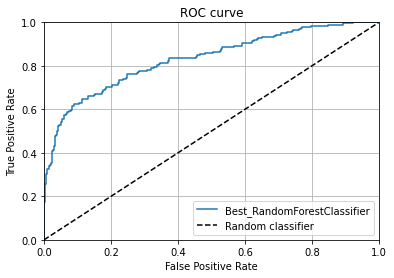

In [32]:
def check_on_test(model, X, y, label):
    '''Вычисляет и выводит на экран сводку опроизводительности модели на 
    тестовом наборе аналогично функции evaluate_model'''
    y_pred = model.predict(X)
    
    print(f'Accuracy: {accuracy_score(y, y_pred):.2f}')
    print(f'F1 score: {f1_score(y, y_pred):.2f}')
    print(f'ROC AUC: {roc_auc_score(y, y_pred):.2f}')
    
    y_scores = model.predict_proba(X)[:, -1]
    
    plot_roc_curve(y, y_scores, label=label)
    plt.show()
    
    
check_on_test(model=best_forest, X=X_test, y=y_test, label='Best_RandomForestClassifier')

Точность на тестовой выборке получилась даже лучше чем на тренировочной, однако это может быть результатом "удачного" разделения на тренировочную и тестовую выборки.

## (бонус) Проверьте модели на адекватность

Чтобы убедиться, что итоговая модель сделана не зря, проверим на тестовой выборке базовую модель, которая предсказывает целевую переменную случайным образом, и сравним результаты.

Accuracy: 0.58
F1 score: 0.32
ROC AUC: 0.51


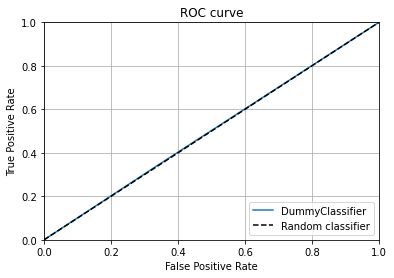

In [33]:
check_on_test(model=dummy_clf.fit(X_train, y_train), X=X_test, y=y_test, label='DummyClassifier')

Полученные значения метрик значительно ниже, чем у конвейра `best_forest`.

## Вывод

Среди рассмотренных простых моделей лучший результат показал `RandomForestClassifier`, даже сам по себе классификатор без настройки гиперпараметров показал по результатам кросс-валидации точность выше 0.75.

После настроек гиперпарамеров лучшие результаты среди всех моделей показал конвейер без апсемплинга:
```Python
best_forest = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=None)),
    ('classifier', RandomForestClassifier(n_estimators=178,
                                          min_samples_split=36,
                                          max_depth=40,
                                          class_weight=None)),
])
```

Значения метрик для финальной модели (`best_forest`) значительно выше, чем для `DummyClassifier`, 
то есть полученная модель адекватна, и её использование имеет смысл.